In [1]:
%matplotlib notebook

import json_lines
from collections import defaultdict

import jieba
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import datetime
import numpy as np
import seaborn as sns

from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import LinearSVC

font = font_manager.FontProperties(fname='msjh.ttc', size=14)
sns.set(style='whitegrid')

In [2]:
# load ptt posts

path = 'output\Gossiping-1000.json'
target_day = datetime.date(2017, 6, 1)

# with open(path, 'rb') as f:
#     for post in json_lines.reader(f):
#         print(post['title'])

# Comment Analysis

In [3]:
# get pushes

total_comments = defaultdict(int)
total_pushes = defaultdict(int)
total_hates = defaultdict(int)

with open(path, 'rb') as f:
    for post in json_lines.reader(f):
        for comment in post['comments']:
            user = comment['user']
            total_comments[user] += 1

            if comment['score'] > 0:
                total_pushes[user] += 1

            elif comment['score'] < 0:
                total_hates[user] += 1

In [4]:
def show_distributions(counts, pushes, hates):
    sorted_cnts = [t[0] for t in sorted(counts.items(), key=lambda x: -x[1])][:100]
    y = [counts[u] for u in sorted_cnts]
    y_pushes = [pushes[u] for u in sorted_cnts]
    y_hates = [hates[u] for u in sorted_cnts]
    x = range(len(y))
    top_names = [x for x in sorted_cnts]
    
    f, ax = plt.subplots(figsize=(10, 6))
    
    sns.set_color_codes('pastel')
    sns.plt.plot(x, y, label='Total {}'.format('comments'), color='blue')
    sns.plt.plot(x, y_pushes, label='Total {}'.format('pushes'), color='green')
    sns.plt.plot(x, y_hates, label='Total {}'.format('hates'), color='red')
    
    ax.legend(ncol=3, loc='upper right', frameon=True)
    ax.set(ylabel='counts',
           xlabel='',
           title='Total comments')
#     ax.set_xticklabels(top_names, rotation=0, fontproperties=font)
    sns.despine(left=True, bottom=True)

    plt.show(f)
#     for user in top_names:
#         print(user)

<IPython.core.display.Javascript object>


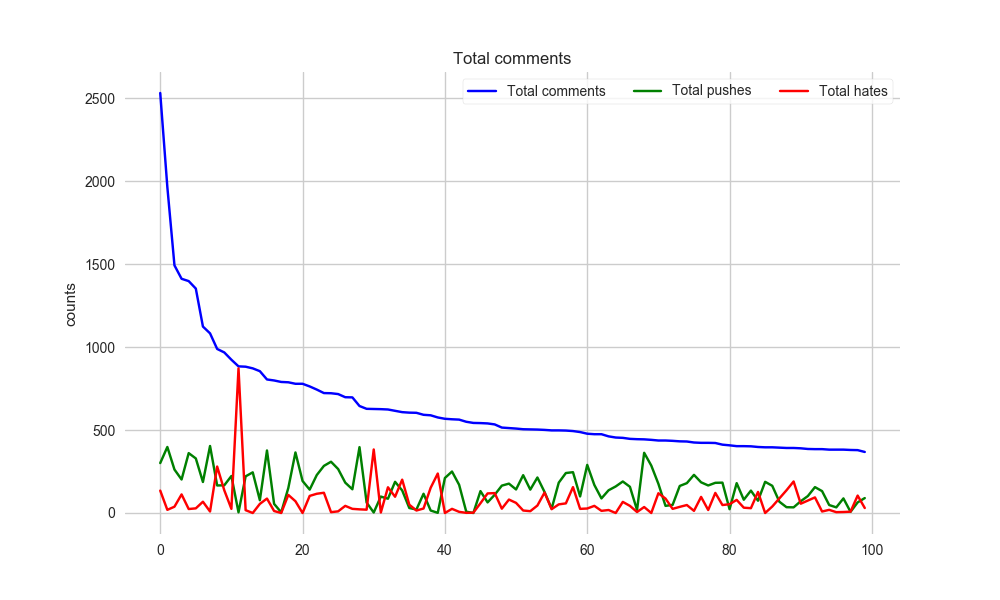

formatted
VVizZ
Nikon610
JingP
wuyiulin
kuninaka
GSHARP
Tchachavsky
louis10452
Rrrxddd
VOLK11
GGrunrundela
xjp004123
hongtm
ymuit
remarkand
realtw
around14357
event1408472
g8330330
qekezfeed
AppleOuO
meredith001
maple0425
Dinenger
superflyy
mhlee
DataMaster
a94037501
kolod546
jimmmy
CenaC
lolic
diabolica
Mesenne
david1230
wowpoqwow
chen22
tim121507
shevchen
sd09090
kmtlikeslave
arrenwu
vyeight
ev331
demitri
stayawesome
sclbtlove
winu
goldman0204
gankgf
SupCat
Howard61313
tml7415
vow70
kent
tiffcmh
f124
Whitening
linceass
akway
chara117yun
ZMittermeyer
nacy204327
zeumax
sayt5943
gaym19
hamasakiayu
SHIU0315
em4
orfan
cake10414
kngs555
taikonkimo
aggressorX
sysop5566
EfiwymsiAros
Refauth
fantasibear
SoLaYo
SuperUp
silentence
melissalewis
frommr
limoncool
kutkin
hijkxyzuw
aaaa714714
yuugen2
uke3458
cy4750
henry3744
snsdakb48
cytotoxic
james732
smalltwo
ray90910
aa1052026
soria
Benbenyale


In [5]:
# display pushes
show_distributions(total_comments, total_pushes, total_hates)

# Word Analysis

In [6]:
# grap post
words = []
scores = []

with open(path, 'rb') as f:
    for post in json_lines.reader(f):
        d = defaultdict(int)
#         jieba.set_dictionary('dict.txt.big')

        post_date_str = post['date']
        post_date = datetime.datetime.strptime(post_date_str, '%Y-%m-%d %H:%M:%S')
         

        if (post_date.date() == target_day):
#             print (post_date)
            content = post['content']
            if post['score'] != 0:
                for l in content.split('\n'):
                    if l:
                        for w in jieba.cut(l):
                            d[w] += 1
                if len(d) > 0:
                    words.append(d)
                    scores.append(1 if post['score'] > 0 else 0)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\蔡奇宏\AppData\Local\Temp\jieba.cache
Loading model cost 0.669 seconds.
Prefix dict has been built succesfully.


In [7]:
# grap comments
c_words = []
c_scores = []

with open(path, 'rb') as f:
    for post in json_lines.reader(f):
        
        post_date_str = post['date']
        post_date = datetime.datetime.strptime(post_date_str, '%Y-%m-%d %H:%M:%S')

        
        if (post_date.date() == target_day):
            for comment in post['comments']:
                l = comment['content'].strip()
                if l and comment['score'] != 0:
                    d = defaultdict(int)
                    for w in jieba.cut(l):
                        d[w] += 1
                    if len(d) > 0:
                        c_scores.append(1 if comment['score'] > 0 else 0)
                        c_words.append(d)

In [8]:
# convert to vectors
dvec = DictVectorizer()
tfidf = TfidfTransformer()
X = tfidf.fit_transform(dvec.fit_transform(words))

c_dvec = DictVectorizer()
c_tfidf = TfidfTransformer()
c_X = c_tfidf.fit_transform(c_dvec.fit_transform(c_words))

In [9]:
svc = LinearSVC()
svc.fit(X, scores)

c_svc = LinearSVC()
c_svc.fit(c_X, c_scores)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [10]:
def display_top_features(weights, names, top_n, select=abs):
    
    
    top_features = sorted(zip(weights, names), key=lambda x: select(x[0]), reverse=True)[:top_n]
    top_weights = [x[0] for x in top_features]
    top_names = [x[1] for x in top_features]

    fig, ax = plt.subplots(figsize=(10,8))
    ind = np.arange(top_n)
    bars = ax.bar(ind, top_weights, color='blue', edgecolor='black')
    for bar, w in zip(bars, top_weights):
        if w < 0:
            bar.set_facecolor('red')
   
    width = 0.30
    ax.set_xticks(ind + width)
    ax.set_xticklabels(top_names, rotation=90, fontproperties=font)

    plt.show(fig)
    
    for word in top_names:
        print (word)

<IPython.core.display.Javascript object>


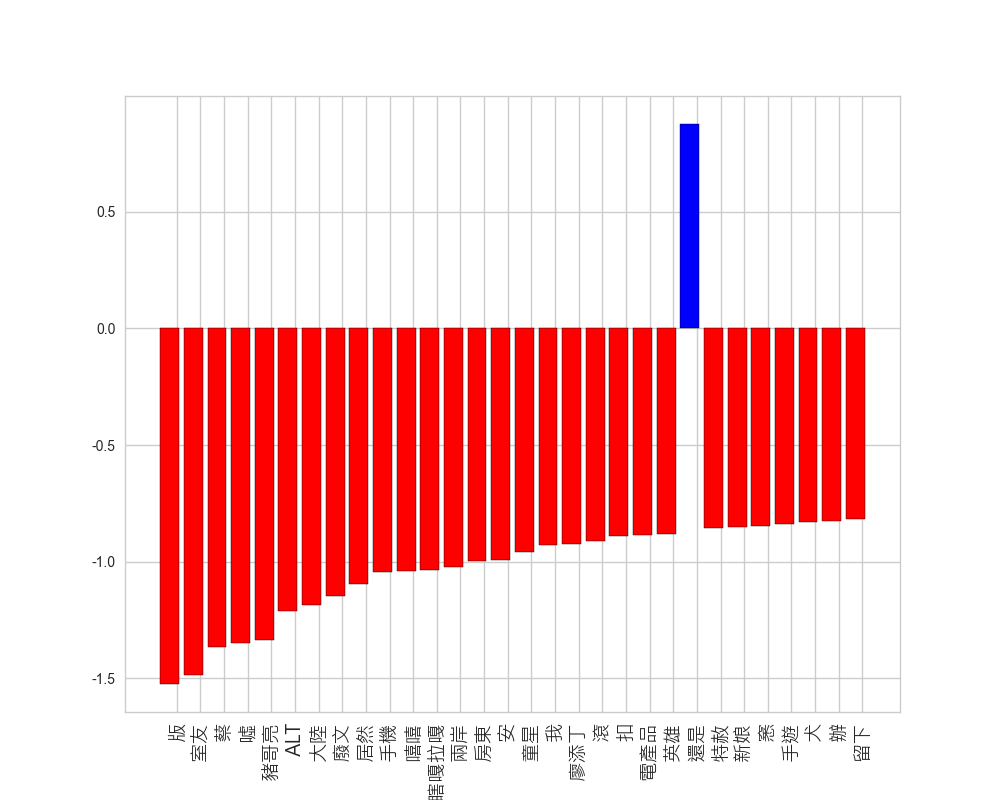

版
室友
蔡
噓
豬哥亮
ALT
大陸
廢文
居然
手機
嘻嘻
蹦瞎嘎拉嘎
兩岸
房東
安
童星
我
廖添丁
滾
扣
電產品
英雄
還是
特赦
新娘
窸
手遊
犬
辦
留下


In [11]:
# top features for posts
display_top_features(svc.coef_[0], dvec.get_feature_names(), 30)

<IPython.core.display.Javascript object>


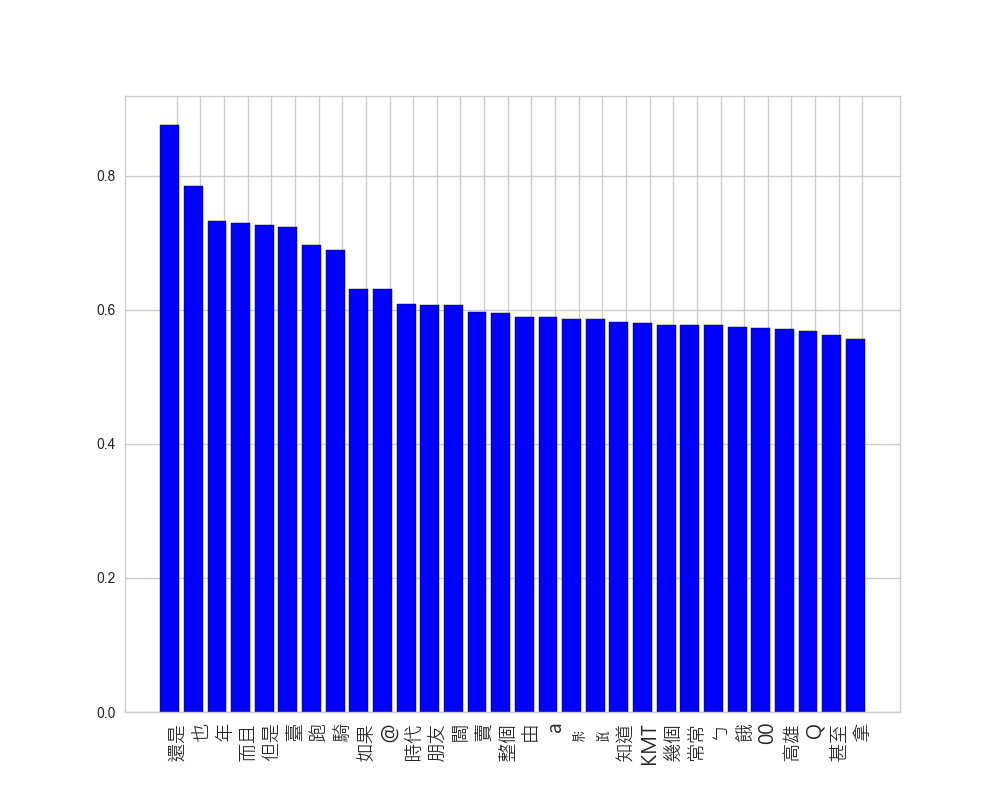

還是
也
年
而且
但是
臺
跑
騎
如果
@
時代
朋友
闆
賣
整個
由
a
縣
蹤
知道
KMT
幾個
常常
ㄅ
餓
00
高雄
Q
甚至
拿


In [12]:
# top positive features for posts
display_top_features(svc.coef_[0], dvec.get_feature_names(), 30, select=lambda x: x)

<IPython.core.display.Javascript object>


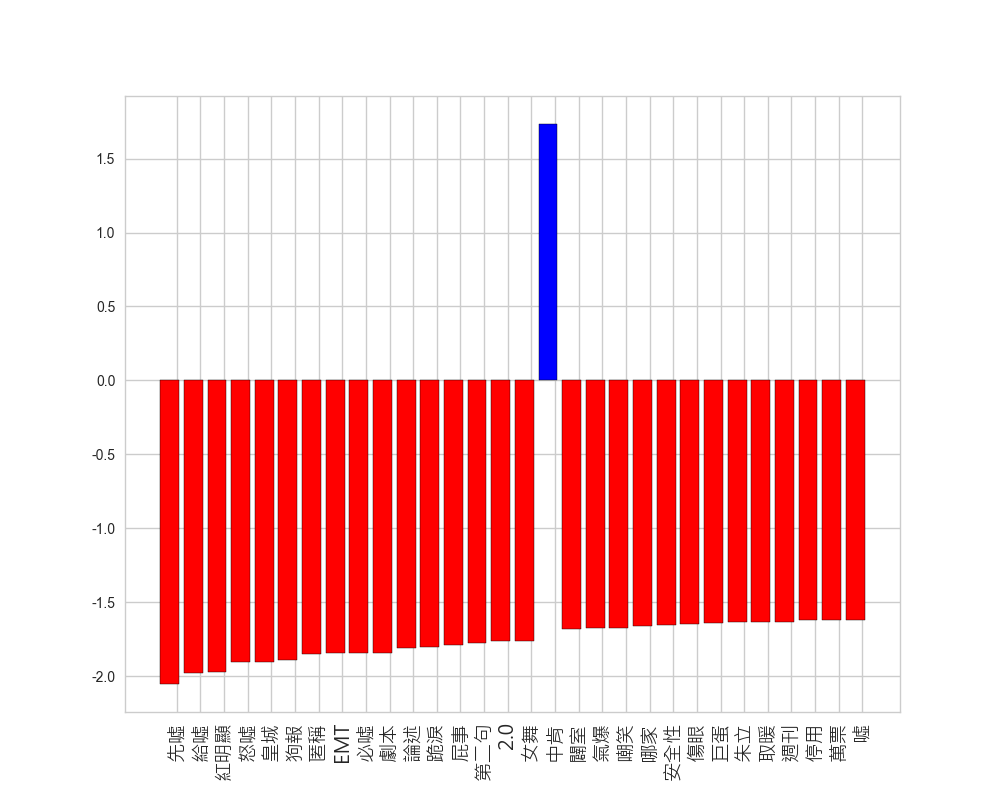

先噓
給噓
紅明顯
怒噓
皇城
狗報
匿稱
EMT
必噓
劇本
論述
跪淚
屁事
第二句
2.0
女舞
中肯
闢室
氣爆
嘲笑
哪家
安全性
傷眼
巨蛋
朱立
取暖
週刊
停用
萬票
噓


In [13]:
# top features for comments
display_top_features(c_svc.coef_[0], c_dvec.get_feature_names(), 30)

<IPython.core.display.Javascript object>


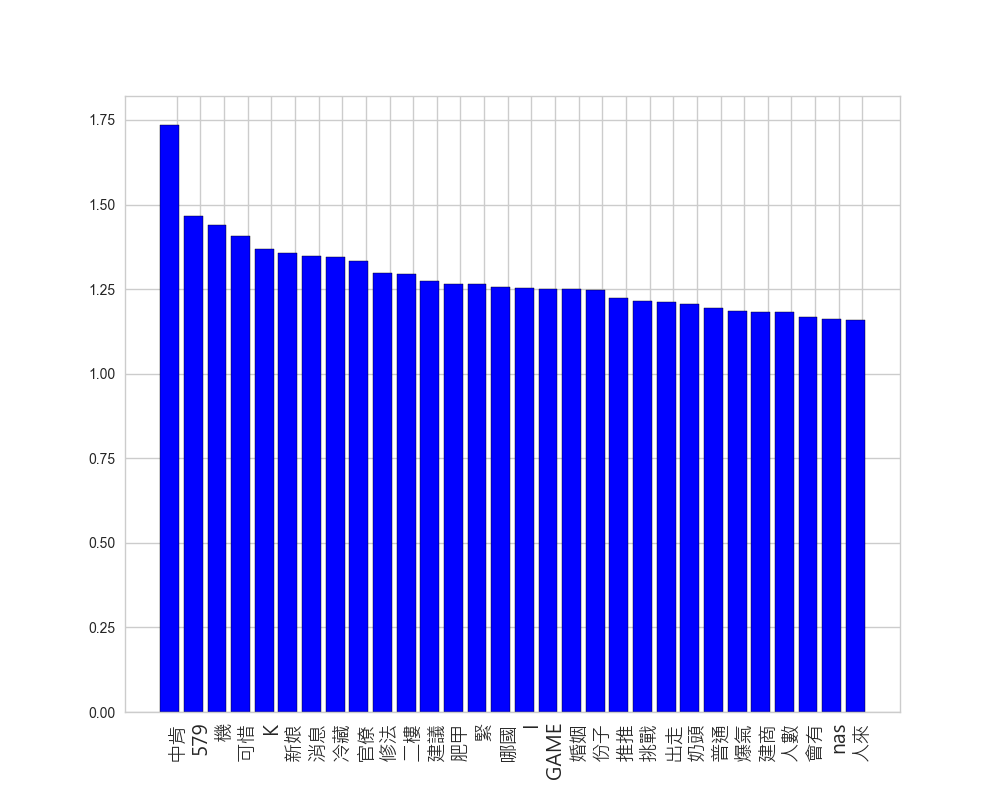

中肯
579
機
可惜
K
新娘
消息
冷藏
官僚
修法
二樓
建議
肥甲
緊
哪國
I
GAME
婚姻
份子
推推
挑戰
出走
奶頭
普通
爆氣
建商
人數
會有
nas
人來


In [14]:
# top positive features for comments
display_top_features(c_svc.coef_[0], c_dvec.get_feature_names(), 30, select=lambda x: x)